# Code for testing the vignette pipeline #

### Step 1: Setup ###

In [1]:
import os
import sys
import json
from pathlib import Path
import open3d as o3d
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# get the root for importing test data
os.environ["SAM_BACKEND"] = "coreml"
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import pipeline modules
from pipeline import segmentation, pointcloud

scikit-learn version 1.7.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.5.1. Disabling scikit-learn conversion API.
Torch version 2.8.0 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.


In [3]:
# Configuration
VIGNETTE_NAME = "capture1"
VIGNETTE_PATH = project_root / "test_data" / VIGNETTE_NAME
print(f"Project Root: {project_root}")
print(f"Testing Vignette: {VIGNETTE_PATH}")

Project Root: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer
Testing Vignette: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1


### Step 2: SAM Segmentation ###

In [4]:
# Paths for the inputs and outputs
rgb_path = VIGNETTE_PATH / "rgb.png"
metadata_path = VIGNETTE_PATH / "metadata.json"
results_path = VIGNETTE_PATH / "results"

In [5]:
# UV for testing
uv_coords = [0.5, 0.5]

# Run SAM to get raw logits
logits_path = segmentation.generate_sam_logits(
    rgb_image_path=rgb_path,
    uv_coords=uv_coords,
    output_path=results_path
)
print(f"Logits generated and saved to: {logits_path}")

[sam2] Loading CoreML SAM2 models…
[sam2] Saved CoreML SAM2 logits: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/mask_logits.npy shape=(1440, 1920)
Logits generated and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/mask_logits.npy


[sam] Wrote mask: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/mask.png
Mask created and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/mask.png


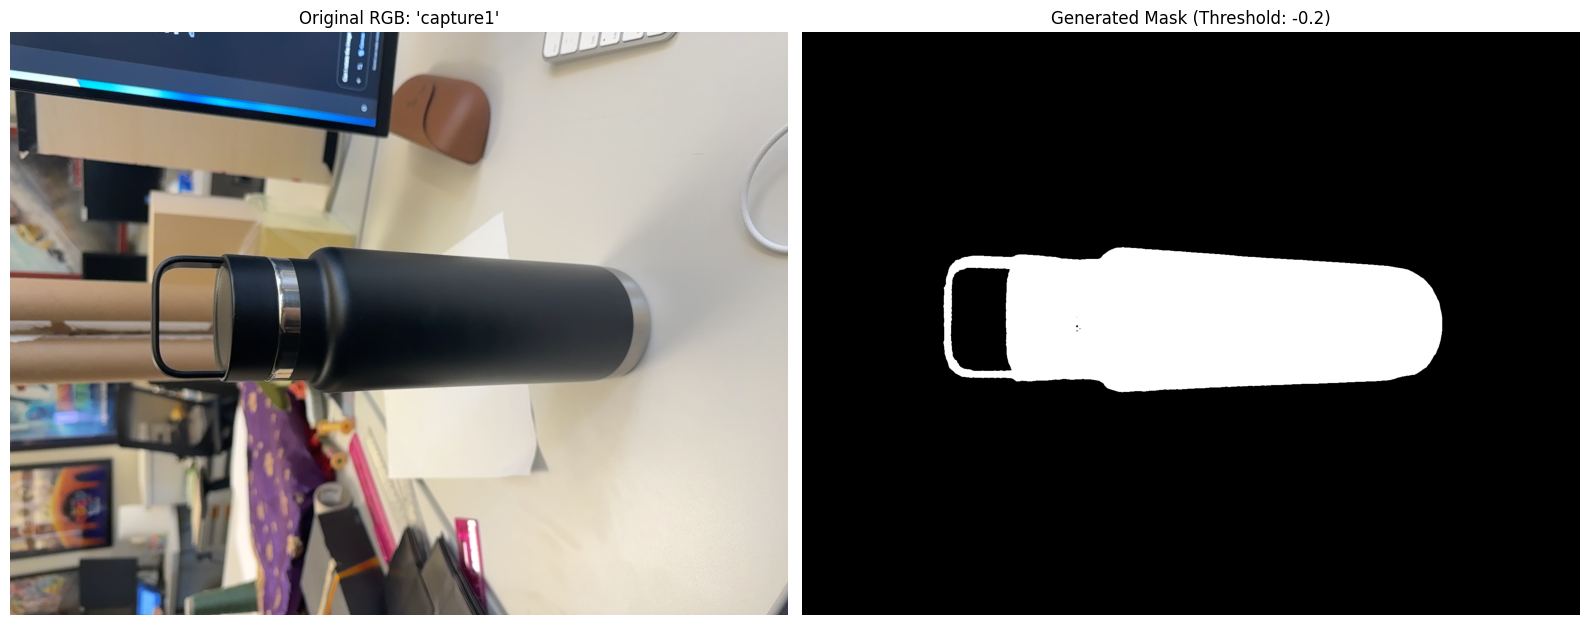

In [6]:
sam_threshold = -0.2
# Apply the threshold
mask_path = segmentation.apply_threshold_to_logits(
    logits_path=logits_path,
    threshold=sam_threshold,
    output_path=results_path
)
print(f"Mask created and saved to: {mask_path}")

# Display
rgb_image = Image.open(rgb_path)
mask_image = Image.open(mask_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(rgb_image)
axes[0].set_title(f"Original RGB: '{VIGNETTE_NAME}'")
axes[0].axis('off')

axes[1].imshow(mask_image, cmap='gray')
axes[1].set_title(f"Generated Mask (Threshold: {sam_threshold})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Step 3: Generate Point Cloud ###

In [7]:
# get point cloud
pcd_path = pointcloud.create_masked_point_cloud(VIGNETTE_PATH)
if pcd_path:
    pcd = o3d.io.read_point_cloud(str(pcd_path))

Processing point cloud for: capture1
Scaled intrinsics (fx, fy) from (1391.40, 1391.40) to (185.52, 185.52)
Generated and centered point cloud with 6021 points.
Saved masked point cloud to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture1/results/masked_point_cloud.ply


Downsampled point cloud from 6021 to 1420 points for plotting.


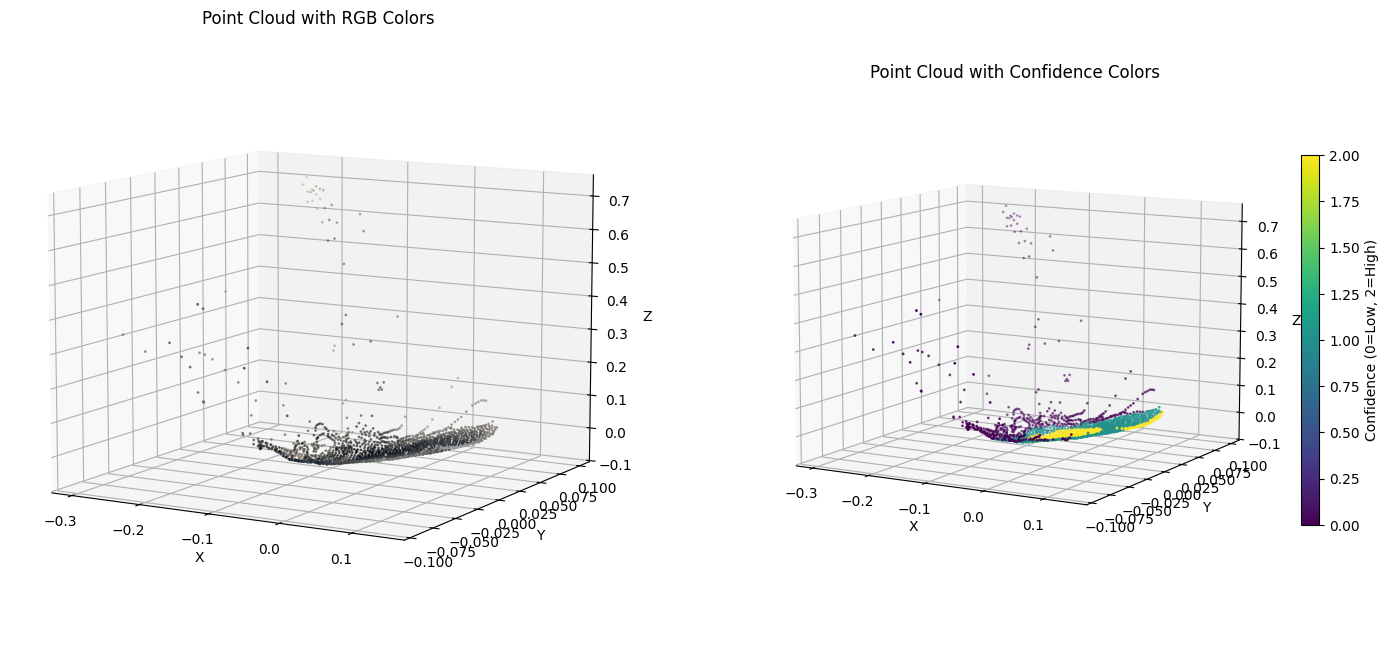

In [13]:
from mpl_toolkits.mplot3d import Axes3D
voxel_size = 0.005
pcd_downsampled = pcd.voxel_down_sample(voxel_size)
print(f"Downsampled point cloud from {len(pcd.points)} to {len(pcd_downsampled.points)} points for plotting.")

points = np.asarray(pcd_downsampled.points)
colors = np.asarray(pcd_downsampled.colors)

confidence_path = VIGNETTE_PATH / "results" / "masked_confidences.npy"
if confidence_path.exists():  
    # Find which confidence values correspond to our downsampled points
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    confidences_downsampled = []
    full_confidences = np.load(confidence_path)
    for point in pcd_downsampled.points:
        [k, idx, _] = pcd_tree.search_knn_vector_3d(point, 1)
        confidences_downsampled.append(full_confidences[idx[0]])
    confidences = np.array(confidences_downsampled)
else:
    # Fallback if confidence file is missing
    confidences = np.zeros(len(points))
    print("Confidence file not found. Using zero values.")

x, y, z = points[:, 0], points[:, 1], points[:, 2]

# --- 3. Create the Side-by-Side 3D Plot ---
fig = plt.figure(figsize=(18, 8))

# --- Plot 1: Original RGB Colors ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z, c=colors, s=1) # s=1 makes the points small
ax1.set_title('Point Cloud with RGB Colors')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax1.view_init(elev=10, azim=-60)

# --- Plot 2: Confidence Colors ---
ax2 = fig.add_subplot(122, projection='3d')
# Here, `c` is the array of confidence values, and `cmap` maps them to a color gradient.
scatter2 = ax2.scatter(x, y, z, c=confidences, cmap='viridis', s=1, vmin=0, vmax=2)
ax2.set_title('Point Cloud with Confidence Colors')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.view_init(elev=10, azim=-60)
    
# Add a color bar to show what the confidence colors mean
cbar = fig.colorbar(scatter2, ax=ax2, shrink=0.6)
cbar.set_label('Confidence (0=Low, 2=High)')

plt.show()

In [ ]:
def display_geometries(geometries: list, window_name: str = "Open3D"):
    """
    A stable, non-freezing method for visualizing Open3D geometries in a new window.
    
    This function manually controls the lifecycle of the visualizer to prevent
    the Jupyter kernel from hanging after the window is closed.
    """
    # 1. Create a Visualizer object
    vis = o3d.visualization.Visualizer()
    
    # 2. Create the window with a custom name
    vis.create_window(window_name=window_name)
    
    # 3. Add each geometry to the visualizer
    for geometry in geometries:
        vis.add_geometry(geometry)
        
    # 4. Run the visualizer (this is the blocking call that shows the window)
    vis.run()
    
    # 5. Explicitly destroy the window after it is closed. This is the crucial step.
    vis.destroy_window()

In [ ]:
# Visualize Points
display_geometries([pcd], window_name="Points")

In [ ]:
# Visualize Confidence
confidence_path = VIGNETTE_PATH / "results" / "masked_confidences.npy"
if not confidence_path.exists():
    print(f"Confidence file not found at {confidence_path}. Cannot create confidence color map.")
else:
    confidences = np.load(confidence_path)
    if len(confidences) != len(pcd.points):
        print("Confidence count mismatch")
    else:
        import matplotlib.cm as cm
        normalized_confidences = confidences / 2.0
        confidence_colors = cm.viridis(normalized_confidences)[:, :3]
        pcd_confidence = pcd
        pcd_confidence.colors = o3d.utility.Vector3dVector(confidence_colors)
        display_geometries([pcd_confidence], window_name="Points (confidence)")

### Step 4: Preprocess Point Cloud ###

In [ ]:
from pipeline import preprocessing

# Load the raw point cloud we generated in the previous step
raw_pcd_path = VIGNETTE_PATH / "results" / "masked_point_cloud.ply"
raw_pcd = o3d.io.read_point_cloud(str(raw_pcd_path))
    
# Load the corresponding full confidence data
full_confidence_path = VIGNETTE_PATH / "results" / "masked_confidences.npy"
full_confidences = np.load(full_confidence_path)

# Run the preprocessing pipeline
cleaned_pcd = preprocessing.preprocess_point_cloud(
    pcd=raw_pcd,
    confidence_values=full_confidences,
    confidence_threshold=1,     # Remove points with confidence 0
    voxel_size=0.01,            # 1cm grid size for downsampling
    sor_nb_neighbors=20,        # Number of neighbors to check
    sor_std_ratio=2.0           # Standard deviation ratio (higher is less strict)
)

# Before vs. After
print("\nVisualizing the effect of preprocessing...")
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 8))

# Before
ax1 = fig.add_subplot(121, projection='3d')
        # We downsample the raw cloud just for visualization performance
        raw_pcd_viz = raw_pcd.voxel_down_sample(0.01)
        ax1.scatter(
            np.asarray(raw_pcd_viz.points)[:, 0],
            np.asarray(raw_pcd_viz.points)[:, 1],
            np.asarray(raw_pcd_viz.points)[:, 2],
            c=np.asarray(raw_pcd_viz.colors), s=1
        )
        ax1.set_title(f"Before Preprocessing ({len(raw_pcd_viz.points)} points)")
        ax1.view_init(elev=30, azim=-60)

        # --- Plot 2: After (Cleaned) ---
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(
            np.asarray(cleaned_pcd.points)[:, 0],
            np.asarray(cleaned_pcd.points)[:, 1],
            np.asarray(cleaned_pcd.points)[:, 2],
            c=np.asarray(cleaned_pcd.colors), s=1
        )
        ax2.set_title(f"After Preprocessing ({len(cleaned_pcd.points)} points)")
        ax2.view_init(elev=30, azim=-60)

        plt.show()

        # Overwrite the 'pcd' variable with our new, clean version for the next steps
        pcd = cleaned_pcd

### Step 5: Abstraction ###

In [16]:
from pipeline import abstraction

In [20]:
# Dominant Axis
center, axis, extent = abstraction.extract_dominant_axis(pcd)

# Visualize
axis_line = o3d.geometry.LineSet()
axis_line.points = o3d.utility.Vector3dVector([center - axis * extent[0] / 2, center + axis * extent[0] / 2])
axis_line.lines = o3d.utility.Vector2iVector([[0, 1]])
axis_line.colors = o3d.utility.Vector3dVector([[1, 0, 0]])
print("\nVisualizing dominant axis (red line)...")

display_geometries([pcd, axis_line], window_name="Dominant Axis")

Dominant Axis Analysis: Center=[-0.14674127 -0.00593188  0.33224226], Axis=[ 0.43310556 -0.0420999  -0.90035947], Extent=[0.75751571 0.27504832 0.18466875]

Visualizing dominant axis (red line)...


In [18]:
# --- 5b. Visualize Dominant Planes ---
planes = abstraction.extract_dominant_planes(pcd, distance_threshold=0.01)
    
plane_geometries = [pcd.paint_uniform_color([0.7, 0.7, 0.7])] # Start with the original pcd in gray
colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1]] # Different colors for each plane
    
for i, (eq, plane_pcd) in enumerate(planes):
    # Color each plane with a different color
    plane_pcd.paint_uniform_color(colors[i % len(colors)])
    plane_geometries.append(plane_pcd)
        
print("\nVisualizing dominant planes (in color)...")
display_geometries(plane_geometries, window_name="Dominant Planes")
    


Found plane with 5085 points. 936 points remaining.
Found plane with 586 points. 350 points remaining.
Found plane with 153 points. 197 points remaining.
Found plane with 150 points. 47 points remaining.

Visualizing dominant planes (in color)...


In [ ]:
# Visualize Abstract Mesh
abstract_mesh = abstraction.create_abstract_mesh(pcd, alpha=0.03)
    
print("\nVisualizing abstract mesh with original points...")
display_geometries([pcd, abstract_mesh], window_name="Abstract Mesh")